# Исследование объявлений о продаже квартир

В моем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
data = pd.read_csv(r'C:\Users\anast\Desktop\real_estate_data.csv', sep='\t')
display(data.head(10))
data.info()
data.hist(figsize=(15, 20));

Видим пропуски данных в столбцах, которые частично можем заполнить. Дубликаты в столбце с названием населенных пунктов, а также необходимость изменить тип данных в столбце с датой.

### Предобработка данных

In [3]:
print(data.isnull().sum()) #Посмотрим на пропущенные значения в столбцах
print(data.isnull().sum() / data.shape[0] * 100.00)#выведем процент пропущенных значений в столбцах


    



total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64
total_images             0.000000
last_price               0.000000
total_area               0.000000
first_day_exposition     0.000000
rooms                    0.000000
ceiling_height          38.799105
floors_total             0.362885
living_area              8.029875
floor                    0.000000
is_apartment         

Пропущенные значения можем заменить в следующих стобцах:
    1) Высота потолков, связав с этажностью зданий.
    2) Балконы, заменив на 0, так как там, где пропуски, скорее всего просто нет балконов.
    3) Аппартаменты, там, где пропуски скорее всего должно стоять false.
    4) Столбцы с числом ближайщих водоемов и парков. Там, где пропуски, скорее всего таковых нет.
    5) Пропуски в столбце days_exposition скорее всего допущены из-за ошибки сбора данных.
    6) Для студий площадь кухни можем заменить на 0.

In [4]:
data['balcony'] = data['balcony'].fillna(0) #заменим пропуски в столбце с кол-вом балконов на 0.
data['parks_around3000'] = data['parks_around3000'].fillna(0)#заменим пропуски в столбце с кол-вом парков на 0.
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)#заменим пропуски в столбце с кол-вом прудов на 0.
data['is_apartment'] = data['is_apartment'].fillna(False) 
data.loc[data['studio'] == True, 'kitchen_area'] = 0 
print(data.head(10))



   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0        51.00      8         False  ...   
1             NaN          11.0        18.60      1         False  ...

In [5]:
ceiling_medians = data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_medians.columns = ['median', 'count'] #Нашли медиану для каждой этажности
ceiling_medians.head(10)
for floor in ceiling_medians.index:
    data.loc[(data['ceiling_height'].isna()) & (data['floors_total'] == floor), 'ceiling_height'] = ceiling_medians.loc[floor, 'median'] #Заменяем пропуски на медианные значения по соответствующей этажности 
print(data)
data['ceiling_height'].isna().value_counts() #Посчитаем количество пропущенных значений после сделанной замены


       total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00  2019-03-07T00:00:00      3   
1                 7   3350000.0       40.40  2018-12-04T00:00:00      1   
2                10   5196000.0       56.00  2015-08-20T00:00:00      2   
3                 0  64900000.0      159.00  2015-07-24T00:00:00      3   
4                 2  10000000.0      100.00  2018-06-19T00:00:00      2   
...             ...         ...         ...                  ...    ...   
23694             9   9700000.0      133.81  2017-03-21T00:00:00      3   
23695            14   3100000.0       59.00  2018-01-15T00:00:00      3   
23696            18   2500000.0       56.70  2018-02-11T00:00:00      2   
23697            13  11475000.0       76.75  2017-03-28T00:00:00      2   
23698             4   1350000.0       32.30  2017-07-21T00:00:00      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0                2.70

False    23621
True        78
Name: ceiling_height, dtype: int64

Изменим тип данных в следующих столбцах:
1) Столбец с датой приведем к типу дата.
2) Столбец is_apartment к типу bool


In [6]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #изменяем тип в столбце с датой
data["is_apartment"] = data['is_apartment'].astype('bool')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23621 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21570 non-null  float64       
 13  balcony         

Проверим наличие дубликатов в столбце с названием местности и постараемся их устранить.

In [7]:
data['locality_name'].value_counts() #уникальные значения и их кол-во в столбце.
print(data['locality_name'].unique()) # поиск дубликатов с названием местности
data['locality_name'] = (data['locality_name'].replace('ё', 'е', regex=True))
data.locality_name = (
data.locality_name
    .str.replace('поселок городского типа', 'поселок')
    .str.replace('городской поселок', 'поселок')
    .str.replace('поселок станции', 'поселок')
    .str.replace('коттеджный поселок', 'поселок')
    .str.replace('поселок при железнодорожной станции', 'поселок')
)
list(pd.Series(data.locality_name.unique()).dropna().sort_values())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалево',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'деревня Агалатово',
 'деревня Аро',
 'деревня Батово',
 'деревня Бегуницы',
 'деревня Белогорка',
 'деревня Большая Вруда',
 'деревня Большая Пустомержа',
 'деревня Большие Колпаны',
 'деревня Большое Рейзино',
 'деревня Большой Сабск',
 'деревня Бор',
 'деревня Борисова Грива',
 'деревня Ваганово',
 'деревня Вартемяги',
 'деревня Вахнова Кара',
 'деревня Выскатка',
 'деревня Гарболово',
 'деревня Глинка',
 '

Добавим в таблицу новые столбцы со следующими параметрами:
1)цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
2)день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
3)месяц публикации объявления;
4)год публикации объявления;
5)тип этажа квартиры (значения — «‎первый», «последний», «другой»);
6)расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

### Посчитайте и добавьте в таблицу новые столбцы

In [8]:
data['price_one_metres'] = (data['last_price'] / data['total_area']).round(2)
data['day_of_week'] = data['first_day_exposition'].dt.day_of_week
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
def calculate_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_cat'] = data.apply(calculate_floor, axis=1)
data['cityCenters_nearest_kilometres'] = (data['cityCenters_nearest'] / 1000).round()
print(data.head())



    


   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0         51.0      8         False  ...   
1            2.75          11.0         18.6      1         False  ...   
2            2.55           5.0         34.3      4         False  ...   
3            2.60          14.0          NaN      9         False  ...   
4            3.03          14.0         32.0     13         False  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0          482.0               2.0          755.0         

### Проведите исследовательский анализ данных

Создадим функцию, чтобы строить диаграммы размаха для разных признаков. 







In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# функция, получающая на вход название признака, и возвращающая границы "усов"
def det_whiskers(column):
    stat = data[column].describe()

# межквартирльный размах
    iqr = stat[6] - stat[4]

# левый и правый "ус"
    left_whisker = round(stat[4] - 1.5 * iqr, 2)
    right_whisker = round(stat[6] + 1.5 * iqr, 2)

# левый "ус" не должен быть меньше минимального значения
    if left_whisker < stat[3]: left_whisker = stat[3]

# правый "ус" не должен быть больше максимального значения
    if right_whisker > stat[7]: right_whisker = stat[7]

    return [left_whisker, right_whisker]

Построим диаграмму размаха(используя нашу функцию) и гистограмму для общей площади

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


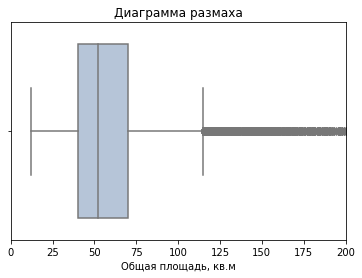

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


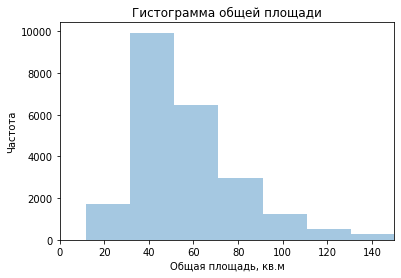

In [10]:
det_whiskers('total_area')
data['total_area'].describe()
# построим диаграмму размаха
sns.boxplot(data['total_area'], color='lightsteelblue')
plt.title('Диаграмма размаха')
plt.xlabel('Общая площадь, кв.м')
plt.xlim(0, 200)
plt.show()
# построим гистограмму
sns.distplot(data['total_area'], kde=False, bins=45)
plt.xlim(0, 150)
plt.title('Гистограмма общей площади')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Частота')
plt.show()


Посмотрев на диаграмму размаха и гистограмму, сделаем вывод, на основании которого будем считать выбросами значения площади более 400м. Очистим данные от выбросов

In [11]:
data = data[data['total_area'] < 400]



Посмотрим на распределение жилой площади.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


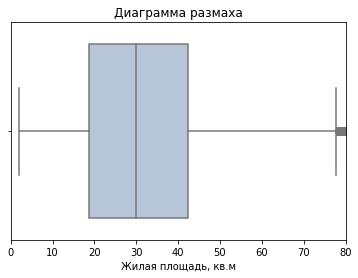

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


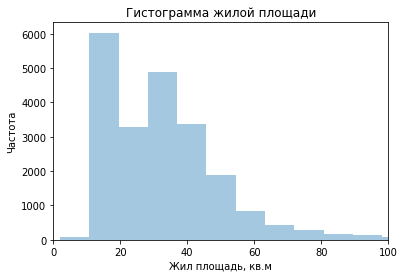

In [12]:
det_whiskers('living_area')
data['living_area'].describe()
# построим диаграмму размаха
sns.boxplot(data['living_area'], color='lightsteelblue')
plt.title('Диаграмма размаха')
plt.xlabel('Жилая площадь, кв.м')
plt.xlim(0, 80)
plt.show()
# построим гистограмму
sns.distplot(data['living_area'], kde=False, bins=30)
plt.xlim(0, 100)
plt.title('Гистограмма жилой площади')
plt.xlabel('Жил площадь, кв.м')
plt.ylabel('Частота')
plt.show()


Будем считать выбросами значения более 60 метров. Удалим их

In [13]:
data = data[(data.living_area < 60) | (data.living_area.isna())]

Посмотрим на распределение площади кухни.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


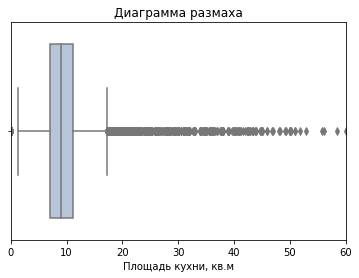

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


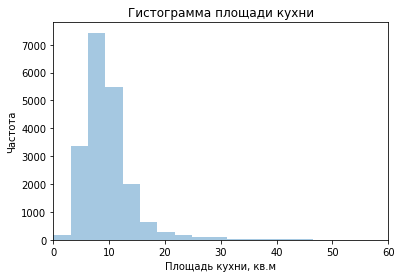

In [14]:
det_whiskers('kitchen_area')
data['kitchen_area'].describe()
# построим диаграмму размаха
sns.boxplot(data['kitchen_area'], color='lightsteelblue')
plt.title('Диаграмма размаха')
plt.xlabel('Площадь кухни, кв.м')
plt.xlim(0, 60)
plt.show()
# построим гистограмму
sns.distplot(data['kitchen_area'], kde=False, bins=30)
plt.xlim(0, 60)
plt.title('Гистограмма площади кухни')
plt.xlabel('Площадь кухни, кв.м')
plt.ylabel('Частота')
plt.show()

Посмотрим на распределение цены объекта

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


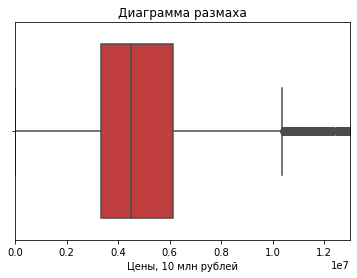

In [15]:
det_whiskers('last_price') #Диаграмма размаха для цены объекта
data['last_price'].describe()
sns.boxplot(data['last_price'], color='tab:red')
plt.title('Диаграмма размаха')
plt.xlabel('Цены, 10 млн рублей')
_ = plt.xlim(0, 13000000)


Удалим квартиры дороже 100млн

In [16]:
data = data[data['last_price'] < 100000000]

Посмотрим на распределение высоты потолков.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


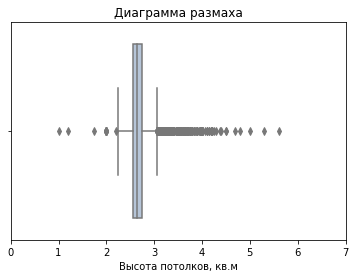

In [17]:
det_whiskers('ceiling_height')
data['ceiling_height'].describe()
# построим диаграмму размаха
sns.boxplot(data['ceiling_height'], color='lightsteelblue')
plt.title('Диаграмма размаха')
plt.xlabel('Высота потолков, кв.м')
plt.xlim(0, 7)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


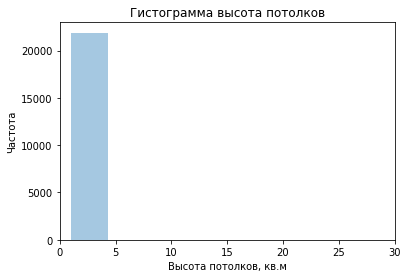

In [18]:
# построим гистограмму
sns.distplot(data['ceiling_height'], kde=False, bins=30)
plt.xlim(0, 30)
plt.title('Гистограмма высота потолков')
plt.xlabel('Высота потолков, кв.м')
plt.ylabel('Частота')
plt.show()

Квартиры с высотой потолков менее 2,4 метров и более 4 являются выбросами. Если высота потолка от 24 до 40 метров, то мы снизим высоту на один разряд. Если высота менее 2,4 метра мы ее увеличим до 2,4. Если высота от более 4 и менее 24 или более 40 мы присвоим ей медианное значение.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(1.0, 4.0)

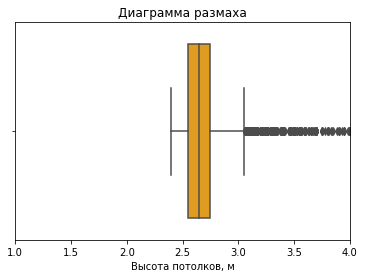

In [19]:
#Разберемся с аномальными значениями высоты потолков
def calculate_ceiling_height(row, median):
    value = row['ceiling_height']
    if value >= 24 and value <= 40: 
        return value / 10
    elif value < 2.4:
        return 2.4
    elif value > 4 and value < 24 or value > 40:
        return median
    return value
median = data.ceiling_height.median()
data['ceiling_height'] = data.apply(axis=1, 
                                    func=calculate_ceiling_height, 
                                    median=median)

det_whiskers('ceiling_height')
data['ceiling_height'].describe()
sns.boxplot(data['ceiling_height'], color='orange')
plt.title('Диаграмма размаха')
plt.xlabel('Высота потолков, м')
plt.xlim(1, 4)



Основные значения высоты потолков находятся в диапазоне от 2,4 до 3 метров.

Посмотрим на распределение типа этажа, предварительно сгруппировав данные в этом столбце. 

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0         51.0      8         False  ...   
1            2.75          11.0         18.6      1         False  ...   
2            2.55           5.0         34.3      4         False  ...   
3            2.60          14.0          NaN      9         False  ...   
4            3.03          14.0         32.0     13         False  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0          482.0               2.0          755.0         

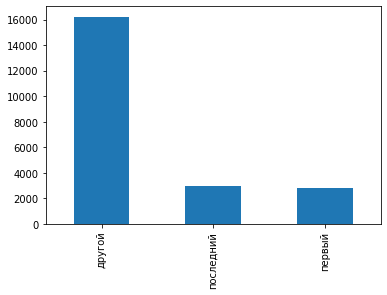

In [20]:
def calculate_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_cat'] = data.apply(calculate_floor, axis=1)
data['cityCenters_nearest_kilometres'] = (data['cityCenters_nearest'] / 1000).round()
print(data.head())

data['floor_cat'].value_counts().plot(kind='bar')
plt.show()

Больше всего квартир, которые находятся не на 1 и не на последнем этаже.

Посмотрим на распределение облщего количества этажей в доме

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


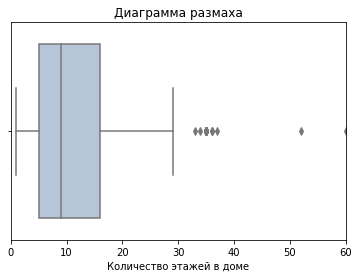

In [21]:
det_whiskers('floors_total')
data['floors_total'].describe()
# построим диаграмму размаха
sns.boxplot(data['floors_total'], color='lightsteelblue')
plt.title('Диаграмма размаха')
plt.xlabel('Количество этажей в доме')
plt.xlim(0, 60)
plt.show()



/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


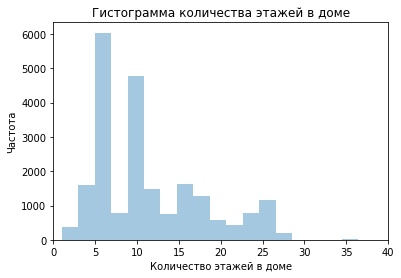

In [22]:
# построим гистограмму
sns.distplot(data['floors_total'], kde=False, bins=30)
plt.xlim(0, 40)
plt.title('Гистограмма количества этажей в доме')
plt.xlabel('Количество этажей в доме')
plt.ylabel('Частота')
plt.show()

Будем считать выбросами колчисетво этажей большее 30. Удалим эти значения.

In [23]:
data = data[(data.floors_total < 30) | (data.floors_total.isna())]

Посмотрим распределение по количеству комнат

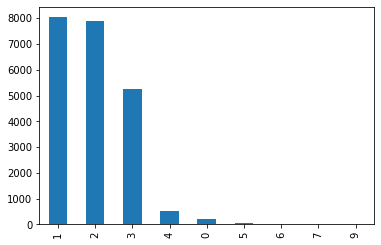

In [24]:
data.rooms.value_counts().plot(kind='bar')
plt.show()

С помощью двойного условия удалим квартиры, в которых количество комнат более 5 или равно 0.

In [25]:
data = data[(data.rooms <= 5) & (data.rooms != 0)]

Посмотрим на распределение расстояния до центра города.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


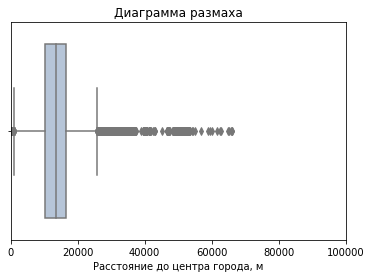

In [26]:
det_whiskers('cityCenters_nearest')
data['cityCenters_nearest'].describe()
# построим диаграмму размаха
sns.boxplot(data['cityCenters_nearest'], color='lightsteelblue')
plt.title('Диаграмма размаха')
plt.xlabel('Расстояние до центра города, м')
plt.xlim(0, 100000)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


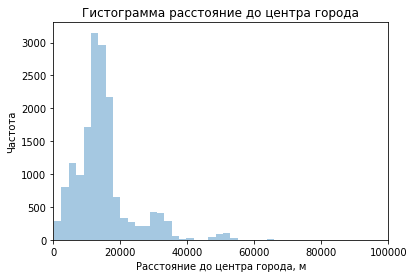

In [27]:
# построим гистограмму
sns.distplot(data['cityCenters_nearest'], kde=False, bins=30)
plt.xlim(0, 100000)
plt.title('Гистограмма расстояние до центра города')
plt.xlabel('Расстояние до центра города, м')
plt.ylabel('Частота')
plt.show()

Будем считать выбросами квартиры, расстояние от которых до центра более 40км. Удалим такие квартиры.

In [28]:
data = data[(data.cityCenters_nearest < 40000) | (data.cityCenters_nearest_kilometres.isna())]

Посмотрим распределение расстояний до ближайшего парка

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


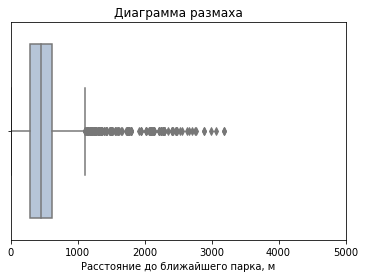

In [29]:
det_whiskers('parks_nearest')
data['parks_nearest'].describe()
# построим диаграмму размаха
sns.boxplot(data['parks_nearest'], color='lightsteelblue')
plt.title('Диаграмма размаха')
plt.xlabel('Расстояние до ближайшего парка, м')
plt.xlim(0, 5000)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


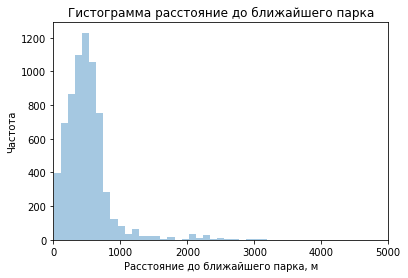

In [30]:
# построим гистограмму
sns.distplot(data['parks_nearest'], kde=False, bins=30)
plt.xlim(0, 5000)
plt.title('Гистограмма расстояние до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка, м')
plt.ylabel('Частота')
plt.show()

Будем считать выбросами те квартиры, где расстояние до парка более 2000м. Удалим такие значения.

In [31]:
data = data[(data.parks_nearest < 2000) | (data.parks_nearest.isna())]

Изучим информацию о том, как быстро продавались квартиры. Построим гистограмму

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


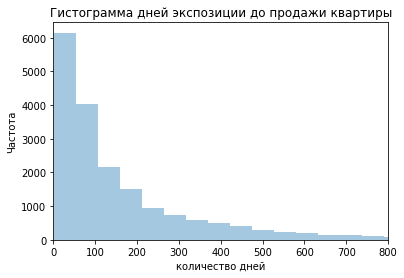

In [32]:
# построим гистограмму
sns.distplot(data['days_exposition'], kde=False, bins=30)
plt.xlim(0, 800)
plt.title('Гистограмма дней экспозиции до продажи квартиры')
plt.xlabel('количество дней')
plt.ylabel('Частота')
plt.show()

Посчитаем среднее и медиану для количества дней экспозиции ( до момента продажи квартиры)

In [33]:
print(data['days_exposition'].mean())
print(data['days_exposition'].median())

173.32885079024913
91.0


В данном случае медиана лучше описывает типичное значение. Большая часть квартир была продана за 1-3 месяца. Квартира продавалась быстро, если была продана менее чем за месяц и медленно, если была продана за 6 месяцев и более.

Изучим, зависит ли цена от общей площади

Коэффициент кореляции Пирсона - 0.702


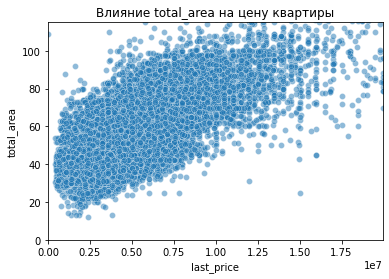

In [34]:
def plot_dependence(data, column, *, alpha=0.1):
    sns.scatterplot(data=data, x='last_price', y=column, alpha=0.5)
    print(f'Коэффициент кореляции Пирсона - {data.last_price.corr(data[column]):.3f}')
    plt.xlim(0, data.last_price.quantile(0.99))
    plt.ylim(0, data[column].quantile(0.99))
    plt.title(f'Влияние {column} на цену квартиры')
    plt.show()
plot_dependence(data, 'total_area')    

Видим, что с ростом площади, растет и цена квартиры. Приблизительно линейно. Связь есть.

Коэффициент кореляции Пирсона - 0.474


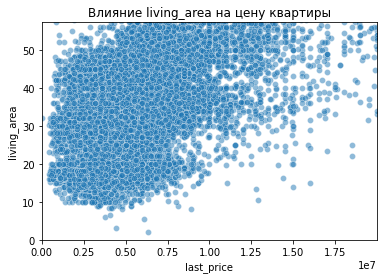

In [35]:
plot_dependence(data, 'living_area')

Коэффициент пирсона уже меньше, связь тоже меньше, однако она все равно просматривается

Коэффициент кореляции Пирсона - 0.593


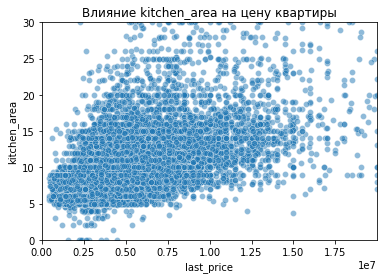

In [36]:
plot_dependence(data, 'kitchen_area')

Связь стала еще менее выраженной, но все же присутствует

Коэффициент кореляции Пирсона - 0.342


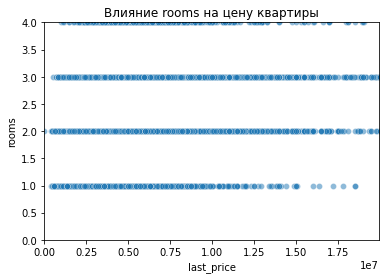

In [37]:
plot_dependence(data, 'rooms')

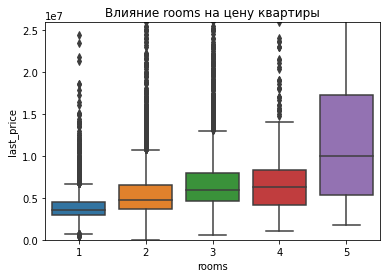

In [38]:
def plot_dependence_cat(data, column, *, lim=0.99):
    sns.boxplot(data=data, y='last_price', x=column)
    plt.ylim(0, data.last_price.quantile(lim))
    plt.title(f'Влияние {column} на цену квартиры')
    plt.show()
plot_dependence_cat(data, 'rooms', lim=0.995)

Влияние количество комнат на цену квартиры также прослеживается.

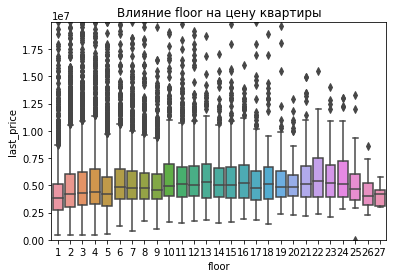

In [39]:
plot_dependence_cat(data, 'floor')

Сначала с увеличением этажа растет и цена на квартиру. Можно отдельно отметить перепад после 1 этажа, который говорит о том, что квартиры на 1 этаже значительно дешевле. После 5 этажа наблюдаем стабилизацию цен на квартиры вплоть до 24 этажа, а далее снижение цены.

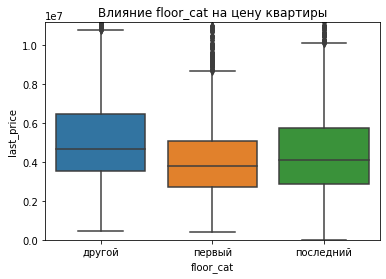

In [40]:
def calculate_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_cat'] = data.apply(calculate_floor, axis=1)
data['cityCenters_nearest_kilometres'] = (data['cityCenters_nearest'] / 1000).round()


plot_dependence_cat(data, 'floor_cat', lim=0.95)

Квартиры на первом и последнем этажах стоят дешевле, чем на остальных. Квартиры на первом этаже существенно дешевле квартир на последнем этаже.

Посмотрим связь цены и даты публикации объявления

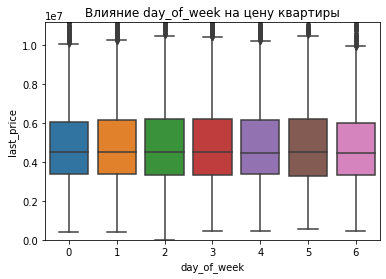

In [41]:
plot_dependence_cat(data, 'day_of_week', lim=0.95)

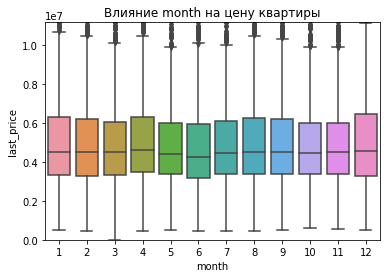

In [42]:
plot_dependence_cat(data, 'month', lim=0.95)

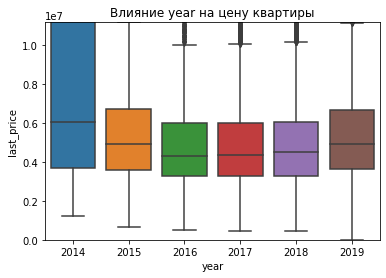

In [43]:
plot_dependence_cat(data, 'year', lim=0.95)

Корреляцию видим только для последней картинки, где в качестве временного промежутка указан год публикации объявления. С 2014 по 2016 год выраженный спад цен на недвижимость, после 2018 года подъем цен.

Общий вывод:
Вывод:
1)Мы видим линейную зависимость между площадью кухни, жилой, общей площадью и ценой квартиры. При увеличении площади растет и цена, о чем нам говорит положителный коэффициент корреляции. Общая площадь коррелирует с ценой наиболее сильно.
2)При увеличении количества комнат цены наших наблюдений растут.
3)Сначала с увеличением этажа у нас наблюдается рост цен на квартиры, с 6 по 24 этаж некоторая стабилизация, а выше 24 снижение цены. 
4)Квартиры находящиеся на первом и последнем этаже, при прочих равных, стоят дешевле. А также квартиры на первом этаже немного дешевле квартир, находящихся на последнем этаже.
5)День недели, и месяц размещения объявления никак не влияет на цену
6)Мы можем заметить что с 2014 года по 2016 год мы наблюдали рост цен недвижимости, с 2016 по 2018 стабилизация цен, а после 2018 цены начали расти.

Посмотрим средние цены за 1 кв.м. по населенным пунктам

In [44]:
price_stat = data.pivot_table(
    index='locality_name', 
    values='price_one_metres', 
    aggfunc=['count', 'mean']
)
price_stat.columns = 'количество', 'средняя цена'
price_stat = price_stat.sort_values(
    by='количество', 
    ascending=False)[:10]
display(price_stat.style.format(
    "{:.2f}", 
    subset=['средняя цена']
).background_gradient(
    cmap='Reds', 
    subset=['средняя цена'] , 
    axis=0
))

,количество,средняя цена
locality_name,,
Санкт-Петербург,13940,110921.81
поселок Мурино,528,85051.14
поселок Шушары,427,78477.24
Всеволожск,387,68533.90
Пушкин,344,102415.56
Колпино,326,75399.18
поселок Парголово,320,90508.89
Гатчина,305,68543.54
деревня Кудрово,280,92090.25


Самая дорогая недвижимость в Санкт-Петербурге и Пушкине, самая дешевая в Выборге.

Посмотрим как меняется цена квадратного метра отдаляясь от центра Санкт-Петербурга

In [45]:
peter = (data[(data.locality_name == 'Санкт-Петербург') &
              (data.cityCenters_nearest_kilometres != 0)])
peter_stat = peter.pivot_table(index='cityCenters_nearest_kilometres', 
                               values='price_one_metres', 
                               aggfunc=['mean', 'median'])
peter_stat.columns = ['среднee', 'медиана']
display(peter_stat.style.format(
    "{:.2f}", 
    subset=['среднee', 'медиана']
).background_gradient(
    cmap='Reds', 
    subset=['среднee', 'медиана'] , 
    axis=0
))


,среднee,медиана
cityCenters_nearest_kilometres,,
1.0,152519.01,128869.05
2.0,145620.23,125000.00
3.0,121507.50,112139.24
4.0,130666.53,123688.12
5.0,138330.23,130081.30
6.0,141175.29,129436.33
7.0,139165.00,122557.67
8.0,123272.54,120147.78
9.0,110529.38,105000.00


Наблюдаем, что по мере удаления от центра города недвижимость дешевеет. Мы наблюдаем на расстоянии 6, 7 км от центра опять повышение цен. И на расстоянии 27 км опять высокие цены.

### Общий вывод

Мы имеем пропуски в столбцах ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name скорее всего из-за того что пользователь не ввел эти данные в форме подачи объявления.

Также мы имеем пропуски в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest. Эти пропуски скорее всего связаны с отсутсвием данных в геосервисах, откуда подгружалась эта информация. Пропуски в столбце days_exposition скорее всего допущены из-за ошибки сбора данных.

В названиях населенных пунктов было много дубликатов(один населенный пункт записанный по-разному)

Распределение общей площади, жилой площади, площади кухни и цена похоже имеет высокие значения, это скорее всего элитная недвижимость имеющая огромную площадь. Основная часть наших квартир имеет высоту потолков от 2,4 до 3 метров. В наших наблюдениях больше всего пятиэтажек и девятиэтажек. Основа нашей выборки состоит из 1, 2, 3, 4 комнатных квартир. Основная часть объектов выборки находится на расстоянии менее чем 20 км от центра города. Множество объектов нашей выборки находится на расстоянии менее 1км от парка. В столбце ceiling_height были аномально низкие и аномально высокие значения. Эти значения были заменены. Все выбросы были удалены.

Обычно продажа квартиры занимает около 1-4 месяцев. Квартира продалась быстро, если ее продажа заняла менее месяца, и квартира продается долго если ее объвление висит 6 месяцев и более.

Мы Обнаружили линейную зависимость между площадью кухни, жилой, общей площадью и ценой квартиры. С ростом количества комнат цена квартиры растет. Сначала с увеличением этажа у нас наблюдается рост цен на квартиры, с 6 по 24 этаж некоторая стабилизация, а выше 24 снижение цены. Также мы можем заметить, что при увеличении этажа становится меньше элитных квартир. День недели, и месяц размещения объявления никак не влияет на наш target. Мы можем заметить что с 2014 года по 2016 год мы наблюдали рост цен недвижимости, с 2016 по 2018 стабилизация цен, а после 2018 цены начали расти.

Cамая дорогая недвижимость в Санкт-Петербурге и Пушкине, а самая дешевая в Выборге и Гатчине.